<a href="https://colab.research.google.com/github/cgrundman/ml-stethoscope/blob/main/code/ml_stethoscope_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine-Learned Stethoscope

##Import Statements

In [6]:
from google.colab import files, drive
import pandas as pd
import numpy as np

from scipy.io import wavfile
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os

##Load Data From Kaggle

Upload your kaggle.JSON file for kaggle. Click the following link for instructions on how to upload this file:
https://www.kaggle.com/general/156610

In [3]:
files.upload() # Load kaggle.json file
!ls -lha kaggle.json

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 73 Jan  5 20:21 kaggle.json


In [4]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d vbookshelf/respiratory-sound-database

100% 3.68G/3.69G [00:27<00:00, 161MB/s]
100% 3.69G/3.69G [00:27<00:00, 144MB/s]


In [ ]:
!unzip -qq respiratory-sound-database.zip -d respiratory-sound-database

##Read the Data

### a. Display the Data

In [8]:
# Read first audio file
file_path = '/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
file_name = '101_1b1_Al_sc_Meditron.wav'
samp_frequency, wav = wavfile.read(file_path+file_name)

44100
<class 'numpy.ndarray'>
(882000,)


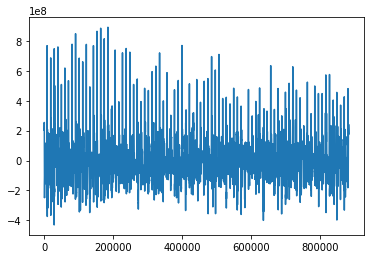

In [ ]:
# Audio(f_name)
plt.plot(wav)
print(samp_frequency)
print(type(wav))
print(np.shape(wav))

### b. Listen to the Data

In [9]:
! pip install -q pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pydub import AudioSegment
import IPython

# We will listen to this file:
# 213_1p5_Pr_mc_AKGC417L.wav

audio_file = '213_1p5_Pr_mc_AKGC417L.wav'

IPython.display.Audio(file_path + audio_file)

## Data Processing

### a.View the files

Let's start by defining our file locations.

In [ ]:
path = '/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/'

Here is the structure of the .csv file. This contains the patient ID (pid) and the diagnosed diesease (disease).

In [ ]:
patient_data=pd.read_csv(f'{path}patient_diagnosis.csv',
                         names=['pid','disease'])

patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


Let's see the annotation for the .txt files.

In [ ]:
txt_file = pd.read_csv(f'{path}audio_and_txt_files/160_1b3_Al_mc_AKGC417L.txt', 
                       sep='\t')

txt_file.head()

,1.862,5.718,0,1
0,5.718,9.725,1,1
1,9.725,13.614,0,1
2,13.614,17.671,0,1
3,17.671,19.541,0,0


Display 5 of the file names.

In [ ]:
path_files = f'{path}audio_and_txt_files/'

file_list = [s.split('.')[0] for s in os.listdir(path_files) if '.txt' in s]
file_list[:5]

['174_1p3_Pl_mc_AKGC417L',
 '176_2b3_Pr_mc_AKGC417L',
 '158_1p3_Ar_mc_AKGC417L',
 '206_1b1_Lr_sc_Meditron',
 '130_3p4_Tc_mc_AKGC417L']

Split a file name into a list.

In [ ]:
def getFilenameInfo(file):
    return file.split('_')

In [ ]:
getFilenameInfo('160_1b3_Al_mc_AKGC417L')

['160', '1b3', 'Al', 'mc', 'AKGC417L']

Create a list with all the information of all of the files

In [ ]:
files_data = []

for file in file_list:
    data = pd.read_csv(path_files + file + '.txt',
                       sep='\t',
                       names=['start','end','crackles','wheezes'])
    name_data = getFilenameInfo(file)
    data['pid'] = name_data[0]
    data['mode'] = name_data[-2]
    data['filename'] = file
    files_data.append(data)

files_df = pd.concat(files_data)
files_df.reset_index()
files_df.head()

,start,end,crackles,wheezes,pid,mode,filename
0,0.326,4.282,1,0,174,mc,174_1p3_Pl_mc_AKGC417L
1,4.282,7.638,1,0,174,mc,174_1p3_Pl_mc_AKGC417L
2,7.638,11.427,1,0,174,mc,174_1p3_Pl_mc_AKGC417L
3,11.427,15.200,1,0,174,mc,174_1p3_Pl_mc_AKGC417L
4,15.200,18.890,1,0,174,mc,174_1p3_Pl_mc_AKGC417L


Now we can join both patient_data and files_df

In [ ]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pid      126 non-null    int64 
 1   disease  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [ ]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 5
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   wheezes   6898 non-null   int64  
 4   pid       6898 non-null   object 
 5   mode      6898 non-null   object 
 6   filename  6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


In [ ]:
patient_data.pid = patient_data.pid.astype('int32')
files_df.pid = files_df.pid.astype('int32')

In [ ]:
data = pd.merge(files_df,patient_data,on='pid')
data.head()

,start,end,crackles,wheezes,pid,mode,filename,disease
0,0.326,4.282,1,0,174,mc,174_1p3_Pl_mc_AKGC417L,COPD
1,4.282,7.638,1,0,174,mc,174_1p3_Pl_mc_AKGC417L,COPD
2,7.638,11.427,1,0,174,mc,174_1p3_Pl_mc_AKGC417L,COPD
3,11.427,15.200,1,0,174,mc,174_1p3_Pl_mc_AKGC417L,COPD
4,15.200,18.890,1,0,174,mc,174_1p3_Pl_mc_AKGC417L,COPD


In [ ]:
os.makedirs('csv_data')
data.to_csv('csv_data/data.csv',index=False)

### b. Process Audio Files

In [ ]:
def getPureSample(raw_data,start,end,sr=22050):
    '''
    Takes a numpy array and spilts its using start and end args
    
    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    
    '''
    max_ind = len(raw_data) 
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

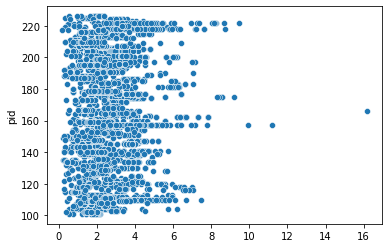

In [ ]:
sns.scatterplot(x=(data.end-data.start), y=data.pid)

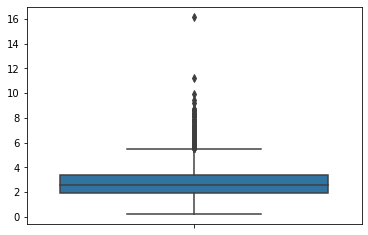

In [ ]:
sns.boxplot(y=(data.end-data.start))

Make a directory to store files

In [ ]:
os.makedirs('processed_audio_files')

Display the rows in data

In [ ]:
for index,row in data.iterrows():
    print("Index ->",index)
    print("Data->\n",row)
    break

Index -> 0
Data->
 start                        0.326
end                          4.282
crackles                         1
wheezes                          0
pid                            174
mode                            mc
filename    174_1p3_Pl_mc_AKGC417L
disease                       COPD
Name: 0, dtype: object


In [ ]:
import librosa as lb
import soundfile as sf


i,c=0,0

for index,row in data.iterrows():
    maxLen = 6
    start = row['start']
    end = row['end']
    filename = row['filename']
    
    # If len > maxLen , change it to maxLen
    if end - start > maxLen:
        end = start + maxLen
    
    audio_file_loc = path_files + filename + '.wav'
    
    if index > 0:
        # check if more cycles exits for same patient if so then add i to change filename
        if data.iloc[index-1]['filename'] == filename:
            i+=1
        else:
            i = 0
    filename = filename + '_' + str(i) + '.wav'
    
    save_path = 'processed_audio_files/' + filename
    c+=1
    
    audioArr,sampleRate = lb.load(audio_file_loc)
    pureSample = getPureSample(audioArr,start,end,sampleRate)
    
    # pad audio if pureSample len < max_len
    reqLen = 6*sampleRate
    padded_data = lb.util.pad_center(pureSample, reqLen)
    
    sf.write(file=save_path,data=padded_data,samplerate=sampleRate)


print('Total Files Processed: ',c)

Total Files Processed:  6898


### c. Show the Data Distribution

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

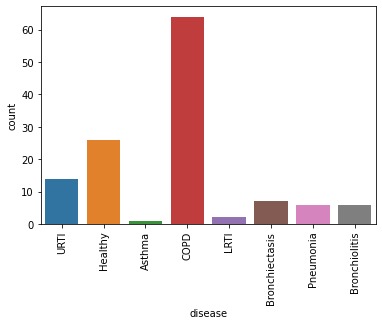

In [ ]:
diagnosis = pd.read_csv(f'{path}patient_diagnosis.csv',
                        names=['pid','disease'])

sns.countplot(diagnosis.disease)
plt.xticks(rotation=90)

In [ ]:
def extractId(filename):
    return filename.split('_')[0]

In [ ]:
processed_path = '/content/processed_audio_files/'
length = len(os.listdir(processed_path))
index = range(length)
i = 0
files_df = pd.DataFrame(index=index,columns=['pid','filename'])

for f in os.listdir(processed_path):
    files_df.iloc[i]['pid'] = extractId(f)
    files_df.iloc[i]['filename'] = f
    i+=1

files_df.head()

,pid,filename
0,107,107_2b5_Al_mc_AKGC417L_7.wav
1,117,117_1b2_Tc_mc_LittC2SE_6.wav
2,207,207_2b4_Pl_mc_AKGC417L_2.wav
3,138,138_2p2_Pl_mc_AKGC417L_2.wav
4,122,122_2b3_Tc_mc_LittC2SE_0.wav


In [ ]:
files_df.pid = files_df.pid.astype('int64')

data = pd.merge(files_df,diagnosis,on='pid')
data.head()

,pid,filename,disease
0,107,107_2b5_Al_mc_AKGC417L_7.wav,COPD
1,107,107_3p2_Al_mc_AKGC417L_4.wav,COPD
2,107,107_2b5_Ll_mc_AKGC417L_7.wav,COPD
3,107,107_2b5_Al_mc_AKGC417L_1.wav,COPD
4,107,107_2b5_Pl_mc_AKGC417L_1.wav,COPD


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

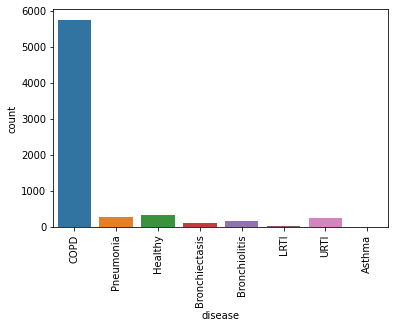

In [ ]:
sns.countplot(data.disease)
plt.xticks(rotation=90)

We can se that the data is very skewed. Now when splittig our data, we have to do this based on disease.

In [ ]:
from sklearn.model_selection import train_test_split


Xtrain,Xval,ytrain,yval = train_test_split(data, 
                                           data.disease,
                                           stratify=data.disease,random_state=42,
                                           test_size=0.25)

Lets take a look at our data after the split.

In [ ]:
print("Disease rate in Xtrain:")
Xtrain.disease.value_counts()/Xtrain.shape[0]

Disease rate in Xtrain:


COPD              0.832979
Healthy           0.046588
Pneumonia         0.041369
URTI              0.035183
Bronchiolitis     0.023197
Bronchiectasis    0.015078
LRTI              0.004639
Asthma            0.000967
Name: disease, dtype: float64

In [ ]:
print("Disease rate in Xval:")
Xval.disease.value_counts()/Xval.shape[0]

Disease rate in Xval:


COPD              0.833043
Healthy           0.046957
Pneumonia         0.041159
URTI              0.035362
Bronchiolitis     0.023188
Bronchiectasis    0.015072
LRTI              0.004638
Asthma            0.000580
Name: disease, dtype: float64

We can see that our split data contains roughly equal amounts of each disease.

### d. Visualizing MFCCS

This will now visualize the MFCC of one file.

[Text(0.5, 1.0, 'MFCC')]

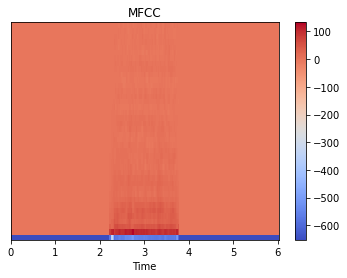

In [ ]:
import librosa.display

file = processed_path + Xtrain.iloc[193].filename 
sound,sample_rate = lb.load(file)
mfccs = lb.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40)
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

Now let's create the csv files of the train and validation data.

In [ ]:
Xtrain.to_csv('train.csv')
Xval.to_csv('val.csv')

## Download Processed Data

This is the code to download this data. Processing takes a long time, so we need to save the data for later use.

In [ ]:
!zip -qq -r /content/processed_audio_files.zip /content/processed_audio_files

In [ ]:
from google.colab import files

files.download('/content/train.csv')
files.download('/content/val.csv')
files.download('/content/processed_audio_files.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Tensor Board

#####Visualize the model performance and statistics from tensorflow settings.

In [ ]:
# load tensorboard
%load_ext tensorboard
# start tensorboard inside the notebook. Outside of the notebook, 
# use tensorboard --logdir=./logs
%tensorboard --logdir=./logs